In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/Movie_Review")
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks/Movie_Review'

In [3]:
from time import sleep
from random import randint

#to hide warnings
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

from requests import get
import re
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# nltk.download('all')
import nltk.corpus
nltk.download('stopwords',quiet=True)
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet',quiet=True)
# nltk.download('vader_lexicon')

True

In [4]:
# Just add the movie IMDB key here
key   = 'tt3614516'
plink = 'https://www.imdb.com/title/' + key

# plink = 'https://www.imdb.com/title/tt3032476/'  #Better Call Saul
# plink = 'https://www.imdb.com/title/tt1292703/'  #Oye Lucky Lucky Oye
# plink = 'https://www.imdb.com/title/tt1639426/'  #Udaan
# plink = 'https://www.imdb.com/title/tt8239946/'  #Tumbadd
# plink = 'https://www.imdb.com/title/tt3614516/'  #Ankho Dekhi

In [5]:
# Defining class for scrapping websites
mv_cls = 'sc-94726ce4-2 khmuXj'
y_cls = 'sc-8c396aa2-2 itZqyK'
rating_cls = 'sc-7ab21ed2-1 jGRxWM'
rev_cls = 'ipc-html-content-inner-div'
# rev_cls = 'ipc-html-content ipc-html-content--base'
top_cls = 'lister-item-content'
detail_rev_cls = 'text show-more__control'
head_rev_cls = 'title'

In [6]:
##
Detail = []
Head = []
##
h1 = ''
d1 = ''

In [7]:
# To get required text from the scrapped data
def clean_print(tx):
    clean = re.compile('<.*?>')
    mv  = (re.sub(clean, '',tx))
    mv = re.sub(r'[^\w\s]', ' ', mv)  # Remove punctuations
    return mv

# Further cleaning common words such as movie
def repl(tx, ls):
    for i in range(len(ls)):
        rep = ls[i]
        if (tx.count(rep) > 0):
            tx = tx.replace(rep,'')
    return tx

In [8]:
# Reviews (sorted by different ideas)
link = plink + '/reviews?sort=totalVotes&dir=desc&ratingFilter=0'
# link = plink + '/reviews?sort=reviewVolume&dir=desc&ratingFilter=0'
# link = plink + '/reviews?sort=curated&dir=desc&ratingFilter=0'
print(link)
##
resp = get(link, verify = False)
ht_so = BeautifulSoup(resp.text, 'lxml')
##
mv = str(ht_so.find('div', class_ = 'parent').find_all('a')[0])
tag = clean_print(mv)
print(tag)
##
rev = ht_so.find_all('div', class_ = top_cls)
print(len(rev))


https://www.imdb.com/title/tt3614516/reviews?sort=totalVotes&dir=desc&ratingFilter=0
Ankhon Dekhi
25


In [9]:
## Additional cleaning
add = list(tag.split(' '))
ls = ['amp','one','give','even','much','watch','film','movie','series','story','cinema','another'] + add

In [10]:
## Creating data of Review Heads and Details
for i in range(len(rev)):
    head = clean_print(str(rev[i].find('a',head_rev_cls))).lower()
    Head.append(head)
    h1 = h1 + head
    detail = clean_print(str(rev[i].find('div',detail_rev_cls))).lower()
    Detail.append(detail)
    d1 = d1+ detail

In [11]:
def tf_clean(df):
    df_clean = []
    for fl in df:
      f1v = fl.lower()
      f1v = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", f1v)
      ##
      f1v = " ".join([word for word in f1v.split() if word not in (stop)])
      ##
      lemmatizer = WordNetLemmatizer()
      f1w = ''
      for word in f1v.split():
          f1w = f1w + ' ' + lemmatizer.lemmatize(word)
      f1x = repl(f1w,ls)
      f1x = " ".join([word for word in f1x.split() if len(word) > 3])
      df_clean.append(f1x)
    return df_clean

In [12]:
# TF-IDF
def tfidf_pro(fl):
  df = tf_clean(fl)
  # Create a TfidfVectorizer object
  tfidf_vectorizer = TfidfVectorizer()

  # Fit and transform the text data
  tfidf_matrix = tfidf_vectorizer.fit_transform(df)

  # Get the feature names
  feature_names = tfidf_vectorizer.get_feature_names_out()
  non_zero_scores = []
  for i in range(tfidf_matrix.shape[0]):
      non_zero_indices = tfidf_matrix[i].nonzero()[1]
      non_zero_words = [feature_names[idx] for idx in non_zero_indices]
      non_zero_scores.extend([(word, tfidf_matrix[i, idx]) for word, idx in zip(non_zero_words, non_zero_indices)])
  ss = 0
  cnt = 0
  scor = []
  tfidf_scores = []
  for word,score in non_zero_scores:
    ss = ss + score
    cnt = cnt + 1
    scor.append(score)

  import statistics
  ss_mean = ss/cnt
  ss_median = statistics.median(scor)
  print('mean of score is ',ss/cnt)
  print('median of score is ',statistics.median(scor))

  for word,score in non_zero_scores:
    if score >= ss_median:
      tfidf_scores.append([word, score])

  # Create a word cloud for words with non-zero TF-IDF scores
  word_cloud_text = ' '.join([word for word, _ in tfidf_scores])
  word_cloud = WordCloud(background_color='white').generate(word_cloud_text)

  # Display the word cloud
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


mean of score is  0.4941027407968073
median of score is  0.47487859037445784


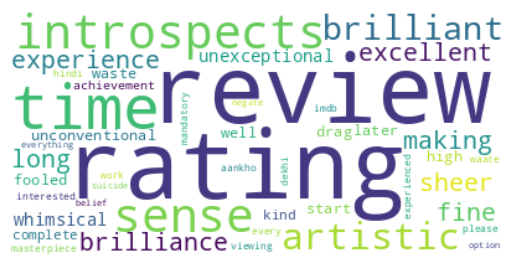

In [13]:
tfidf_pro(Head)

mean of score is  0.08868129693562272
median of score is  0.07516747353170959


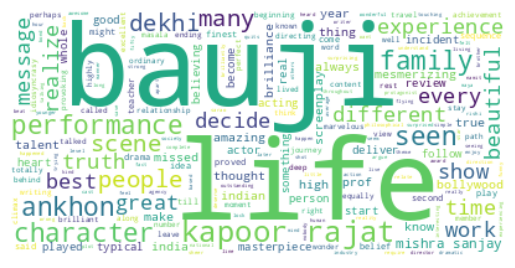

In [14]:
tfidf_pro(Detail)

In [15]:
df = pd.DataFrame(data={"Head": Head, "Detail": Detail})
df.to_csv("./reviews/"+tag+".csv", sep=',',index=False)

,Head,Detail
0,a symbolic witty original modern day fairy ta...,probably simplicity can never be a passé a ...
1,easily one of the best i have ever watched a...,there are lot of indian movies that make large...
2,a man introspects 83 \n,rajat kapoor has always fascinated me with hi...
3,rajat kapoor s ankhon dekhi is another milest...,truth can make you happy miserable and also m...
4,brilliant and artistic in every sense \n,bauji a man in his fifties decides to only be...


In [24]:
# Standard NLP cleaning
def f_clean(fl):
    f1v = fl.lower()
    f1v = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", f1v)
    ##
    f1v = " ".join([word for word in f1v.split() if word not in (stop)])
    ##
    lemmatizer = WordNetLemmatizer()
    f1w = ''
    for word in f1v.split():
        f1w = f1w + ' ' + lemmatizer.lemmatize(word)
    f1x = repl(f1w,ls)
    f1x = " ".join([word for word in f1x.split() if len(word) > 3])
    return f1x

In [25]:
# Get the word cloud on headers
def wcloud(df):
    df_clean = f_clean(df)
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(df_clean)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

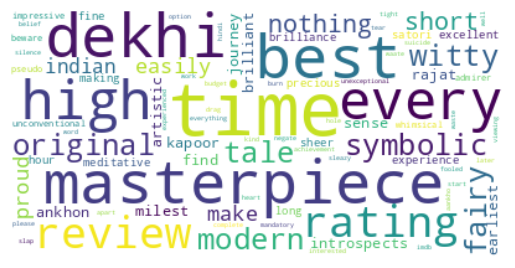

In [26]:
wcloud(h1)

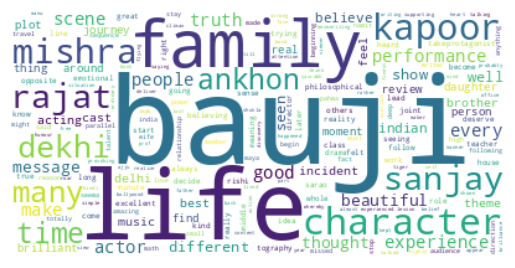

In [27]:
wcloud(d1)

In [23]:
# Sentiment Analyzer
# import nltk
# nltk.download('vader_lexicon')
# sia = SentimentIntensityAnalyzer()
# def senti(fl):
#    sentiment_score = 0  # Variable to store cumulative sentiment score
#    for word in fl.split():
#       sentiment_score += sia.polarity_scores(word)['compound']  # Add sentiment score for each word
#       return sentiment_score

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0.0